<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: Егор Лабинцев – @egor_labintcev

<img src="https://habrastorage.org/web/04d/883/420/04d8834204974f0baf14dc277b634e16.jpg"/>

                         **Случайная картинка из выдачи google по запросу "небаланс классов" :**

## Краткая постановка проблемы

В задачах классификации баланс классов часто нарушается, и обычно именно меньший класс является целевым.

Фрод, отказы техники, положительные медицинские диагнозы, нежелательная выдача в поисковике, отток -- лишь часть примеров таких задач. 

Почему обычные алгоритмы (без шаманства) не слишком хорошо работают?

Если в общих чертах, то дело в том, что внутри многих алгоритмов зашита какая-либо оптимизация [loss](https://en.wikipedia.org/wiki/Loss_function)-функции, часто не учитывающей баланс классов в выборке. Именно поэтому модель стремится предсказать как можно **больше** объектов бОльшего класса, игнорируя меньший класс, но снижая общий error-rate.

В этом tutorial мы рассмотрим некоторые методы, которые позволяют бороться с проблемой неравных классов. 
План такой:

* Внутренние ручки алгоритмов (+ алгоритм для несбалансированных классов)
* Библиотека imbalanced-learn

В качестве модельного датасета будут выступать данные о раздачах в покере (hand), где признаками будут являться карты (масть -- Suit, ранг -- C), а target -- Poker Hand, т.е. различные комбинации имеющихся карт. Датасет можно скачать [здесь](https://archive.ics.uci.edu/ml/datasets/Poker+Hand)

Выдержка из описания features датасета:

```
1) S1 "Suit of card #1" 
Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs} 

2) C1 "Rank of card #1" 
Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King
```

Выдержка о target из описания [датасета](https://archive.ics.uci.edu/ml/datasets/Poker+Hand):

```
0: Nothing in hand; not a recognized poker hand
1: One pair; one pair of equal ranks within five cards
2: Two pairs; two pairs of equal ranks within five cards
3: Three of a kind; three equal ranks within five cards
4: Straight; five cards, sequentially ranked with no gaps
5: Flush; five cards with the same suit
6: Full house; pair + different rank three of a kind
7: Four of a kind; four equal ranks within five cards
8: Straight flush; straight + flush
9: Royal flush; {Ace, King, Queen, Jack, Ten} + flush 
```

Я не большой спец в покере, но чем больше цифра, тем реже класс и тем выигрышнее позиция.

Для примеров нам понадобится .py [скрипт](https://github.com/silicon-valley-data-science/learning-from-imbalanced-classes/blob/master/blagging.py) blagging.py, который можно просто положить рядом с ноутбуком, а также библиотека [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/index.html):

`pip install -U imbalanced-learn`

или для Anaconda 

`conda install -c glemaitre imbalanced-learn`

In [1]:
# Загрузка библиотек

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn import neighbors
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

## Внутренние ручки алгоритмов

Загрузим данные и посмотрим на них:

In [2]:
def load_and_prepare_data():
    
    # Загрузим данные

    df = pd.read_csv('poker-hand-training-true.data', 
                     names=['Suit1', 'C1', 'Suit2', 'C2', 'Suit3', 
                            'C3', 'Suit4', 'C4', 'Suit5', 'C5', 'CLASS'])
    
    # кодирование порядковых (ordinal) признаков -- отдельная тема, здесь обойдемся one-hot

    ordinal_columns = [col for col in df.columns if 'Suit' in col]

    ohe = OneHotEncoder(sparse=False)
    encoded_ordinal = ohe.fit_transform(df[ordinal_columns])

    # удаляем оригинальные колонки
    df.drop(ordinal_columns, axis=1, inplace=True)
    
    tmp = pd.DataFrame(encoded_ordinal, columns=['S ' + str(i) for i in range(encoded_ordinal.shape[1])])
    df = pd.concat([df, tmp], axis=1)
    
    return df

In [3]:
df = load_and_prepare_data()

In [4]:
df.head(10)

,C1,C2,C3,C4,C5,CLASS,S 0,S 1,S 2,S 3,...,S 10,S 11,S 12,S 13,S 14,S 15,S 16,S 17,S 18,S 19
0,10,11,13,12,1,9,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,11,13,10,12,1,9,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,12,11,13,10,1,9,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,10,11,1,13,12,9,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,13,12,11,10,9,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,2,4,5,3,6,8,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,9,12,10,11,13,8,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,1,2,3,4,5,8,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8,5,6,9,7,8,8,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,1,4,2,3,5,8,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Взглянем на распределение классов в выборке, чтобы оценить несбалансированность данных.

In [5]:
# Распределение классов в выборке

print("Initial class percentages: \n")
df.CLASS.value_counts()

Initial class percentages: 



0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
9        5
8        5
Name: CLASS, dtype: int64

In [6]:
X = df.drop('CLASS', axis=1).as_matrix()
y = df.CLASS

Посмотрим на качество алгоритмов as is, предварительно разбив данный на train и test.

В процессе просмотра метрик рекомендую особенно обращать внимание на `recall` классов или на F1-меру.

In [7]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.4, random_state=RANDOM_STATE)

In [8]:
from sklearn.metrics import classification_report

In [9]:
clf = RandomForestClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.55      0.70      0.62      4997
          1       0.48      0.41      0.45      4240
          2       0.10      0.00      0.01       482
          3       0.25      0.00      0.01       205
          4       0.00      0.00      0.00        37
          5       0.00      0.00      0.00        22
          6       0.00      0.00      0.00        14
          7       0.00      0.00      0.00         3
          8       0.00      0.00      0.00         2
          9       0.00      0.00      0.00         2

avg / total       0.49      0.53      0.50     10004



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Как мы видим, наиболее редкие классы дефолтный RandomForest не нашел и ругается на отсутствие предиктов по ним.

Представим на секунду, что нас интересуют классы с 6 по 9 включительно, т.е. редкие, но резко повышающие вероятность победить. Посмотрим, возможно ли подобрать веса таким образом, чтобы найти эти классы.

В некоторых алгоритмах существует возможность проставить `class_weight`, например, у всеми любимой логистической регрессии и случайного леса и таким образом скорректировать штраф за неверно предсказанный объект. Альтернативой ручном подбору является `'balanced'` опция, проставляющая веса в соотвествии с распределением в обучающей выборке.

In [10]:
searching_for_classes = ['balanced', 
                         {6:2, 7:2, 8:2, 9:2},
                         {6:10, 7:10, 8:10, 9:10}
                        ]

In [11]:
for option in searching_for_classes:
    
    clf = RandomForestClassifier(class_weight=option, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)

    print(classification_report(y_test, clf.predict(X_test)))

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.54      0.69      0.60      4997
          1       0.46      0.38      0.42      4240
          2       0.00      0.00      0.00       482
          3       0.17      0.00      0.01       205
          4       0.00      0.00      0.00        37
          5       1.00      0.14      0.24        22
          6       0.00      0.00      0.00        14
          7       0.00      0.00      0.00         3
          8       0.00      0.00      0.00         2
          9       0.00      0.00      0.00         2

avg / total       0.47      0.51      0.48     10004

             precision    recall  f1-score   support

          0       0.55      0.70      0.62      4997
          1       0.47      0.40      0.43      4240
          2       0.17      0.01      0.02       482
          3       0.00      0.00      0.00       205
          4       0.00      0.00      0.00        37
          5       0.00      0.00      0.00

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Теперь посмотрим на ExtraTreesClassifier

In [12]:
for option in searching_for_classes:
    
    clf = ExtraTreesClassifier(class_weight=option, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)

    print('weights: ' + str(option) + '\n' + classification_report(y_test, clf.predict(X_test)) + '\n' )

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


weights: balanced
             precision    recall  f1-score   support

          0       0.52      0.66      0.58      4997
          1       0.44      0.37      0.41      4240
          2       0.05      0.01      0.01       482
          3       0.00      0.00      0.00       205
          4       0.00      0.00      0.00        37
          5       0.82      0.41      0.55        22
          6       0.00      0.00      0.00        14
          7       0.00      0.00      0.00         3
          8       0.00      0.00      0.00         2
          9       0.00      0.00      0.00         2

avg / total       0.45      0.49      0.46     10004




/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


weights: {8: 2, 9: 2, 6: 2, 7: 2}
             precision    recall  f1-score   support

          0       0.51      0.64      0.57      4997
          1       0.43      0.37      0.40      4240
          2       0.05      0.01      0.02       482
          3       0.03      0.00      0.01       205
          4       0.33      0.03      0.05        37
          5       0.82      0.64      0.72        22
          6       0.00      0.00      0.00        14
          7       0.00      0.00      0.00         3
          8       0.00      0.00      0.00         2
          9       0.00      0.00      0.00         2

avg / total       0.45      0.48      0.46     10004


weights: {8: 10, 9: 10, 6: 10, 7: 10}
             precision    recall  f1-score   support

          0       0.51      0.64      0.57      4997
          1       0.43      0.37      0.40      4240
          2       0.06      0.01      0.02       482
          3       0.06      0.01      0.02       205
          4       0.00

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Видим, что в первом случае (при "'balanced'") мы теперь находим 5-ый класс. Впрочем, это не совсем то, чего мы хотели. Посмотрим на вероятности, проставленные классификатором для каждого из классов.

In [13]:
predicted_probs = clf.predict_proba(X_test)

In [14]:
pd.DataFrame(predicted_probs, 
             columns=['prob_' + str(i) for i in range(0,10)]) \
             [["prob_6", "prob_7", "prob_8", "prob_9"]].describe()

,prob_6,prob_7,prob_8,prob_9
count,10004.000000,10004.000000,10004.000000,10004.000000
mean,0.001999,0.000250,0.000200,0.000280
std,0.018865,0.007275,0.005094,0.006157
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.500000,0.500000,0.200000,0.300000


Можно было бы воспользоваться стандартным приемом и выкрутить порог по вероятностям, т.е. назначать класс при меньшем, чем дефолтный 0.5 пороге, поймав часть экземпляров класса. Однако мы видим, что в данном случае такой подход не имеет смысла -- вероятности крайне малы и таких примеров совсем немного.

Мы еще вернемся к проблеме определения столь малых классов.

### Blagging Classifier

Теперь посмотрим на работу Blagging Classifier'а, который из коробки умеет балансировать классы.

Отличное интуитивное представление о работе этого классификатора даст [этот](https://github.com/silicon-valley-data-science/learning-from-imbalanced-classes/blob/master/Gaussians.ipynb) ноутбук, а саму статью с подходом можно найти [здесь](https://pdfs.semanticscholar.org/a8ef/5a810099178b70d1490a4e6fc4426b642cde.pdf).

Ну и исходный [код](https://github.com/silicon-valley-data-science/learning-from-imbalanced-classes/blob/master/blagging.py), конечно.


В общий чертах подход следующий:

* Bootstrap из датасета
* Балансирование путем уменьшения размера большего класса (downsampling)
* Обучение Decision Tree на каждой из выборок
* Majority vote по набору деревьев

<img src="https://habrastorage.org/web/29a/31c/af6/29a31caf67f8449dace109394b8b7e6a.png"/>

Картинка [отсюда](https://svds.com/learning-imbalanced-classes/)

Жаль, но этот классификатор работает только для бинарной классификации, так что мы сведем задачу к такому виду. Пусть у нас есть редкие, но выигрышные классы и несколько классов с наибольшим количеством примеров, не являющиеся выигрышными.

In [15]:
df = load_and_prepare_data()

In [16]:
# еще раз посмотрим на распределение классов

df.CLASS.value_counts()

0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
9        5
8        5
Name: CLASS, dtype: int64

In [17]:
def make_binary(original_data, pos_classes):
    return np.array([(1 if val in pos_classes else 0)
                     for val in original_data ])

In [18]:
binary_y = make_binary(df.CLASS, set((4, 5, 6, 7, 8, 9)))
print("After merging classes {0, 1, 2, 3} -> 0 and {4, 5, 6, 7, 8, 9} -> 1 \n")

np.unique(binary_y, return_counts=True)

After merging classes {0, 1, 2, 3} -> 0 and {4, 5, 6, 7, 8, 9} -> 1 



(array([0, 1]), array([24811,   199]))

Проблема осталось крайне несбалансированной, давайте проверим как поведут себя алгоритмы sklearn и сравним с BlaggingClassifier'ом.

In [19]:
X = df.drop('CLASS', axis=1).as_matrix()
y = binary_y

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.4, random_state=RANDOM_STATE)

RandomForest:

In [20]:
clf = RandomForestClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      9924
          1       0.00      0.00      0.00        80

avg / total       0.98      0.99      0.99     10004



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


GradientBoosting:

In [21]:
clf = GradientBoostingClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      9924
          1       1.00      0.01      0.02        80

avg / total       0.99      0.99      0.99     10004



По-прежнему никаких значительных улучшений, даже после merge классов.

In [22]:
from blagging import BlaggingClassifier

clf = BlaggingClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      0.88      0.94      9924
          1       0.03      0.44      0.05        80

avg / total       0.99      0.88      0.93     10004



Как мы видим, `BlaggingClassifier` отлично показал себя, выдав приличную полноту для такой задачи.

Для меня был сюрпризом результат ExtraTreesClassifier:

In [23]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      9924
          1       0.85      0.21      0.34        80

avg / total       0.99      0.99      0.99     10004



Можно подумать (но мы не будем) о том, как объединить предсказания ExtraTreesClassifier и BlaggingClassifier для лучшего результата.

Давайте теперь посмотрим на AUC-ROC для каждого из классификаторов.
Надо заметить, что стоит строить AUC-ROC на кросс-валидации по фолдам, т.к. некоторые из объектов могут быть нетипичными для класса и это будет заметно при разбиении, а также оценка будет менее смещенной, но мы ограничимся разделением на train-test для демонстрации методов.

In [24]:
clfs = [
        ['RandomForestClassifier', RandomForestClassifier(random_state=RANDOM_STATE)],
        ['GradientBoostingClassifier', GradientBoostingClassifier(random_state=RANDOM_STATE)],
        ['ExtraTreesClassifier', ExtraTreesClassifier(random_state=RANDOM_STATE)], 
        ['BlaggingClassifier', BlaggingClassifier(random_state=RANDOM_STATE)]
       ]

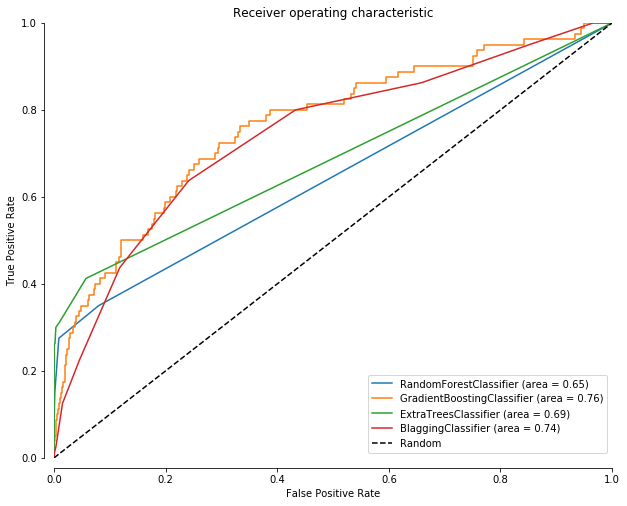

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for name, clf in clfs:
    
    clf.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, linestyle='-',
             label='{} (area = %0.2f)'.format(name) % roc_auc)
    
plt.plot([0, 1], [0, 1], linestyle='--', color='k',
         label='Random')    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

plt.legend(loc="lower right")

plt.show()    

Видно, что за счет "сваливания предсказаний классификатора в больший класс, градиентный бустинг выигрывает у BlaggingClassifier'а.

Но давайте посмотрим на AUC-PR и полноту по редкому классу и всё встанет на свои места.

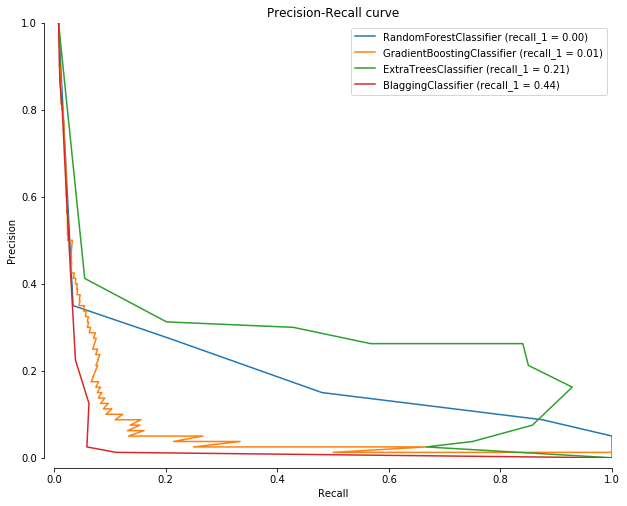

In [26]:
from sklearn.metrics import recall_score

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for name, clf in clfs:
    
    clf.fit(X_train, y_train)
    fpr, tpr, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    recall_1 = recall_score(y_test, clf.predict(X_test))
    plt.plot(fpr, tpr, linestyle='-',
             label='{} (recall_1 = %0.2f)'.format(name) % recall_1)
    
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')

plt.legend(loc="upper right")

plt.show()    

Здесь мы видим, что наибольшая `recall` меньшего класса именно у Blagging Classifier'а.

## Библиотека imbalanced-learn

[Библиотека](http://contrib.scikit-learn.org/imbalanced-learn/install.html) imbalanced-learn позволяет использовать различные техники сэмплирования (как over, так и under, а также их комбинации). Позади некоторых техник стоит нетривиальные подходы, не влезающие в данный туториал, но я оставлю ссылки.

В библиотеку входят:

* Under-sampling methods. Всё просто, сэмплируем из б**о**льшего класса для выравнивания выборки по меньшему классу. Возможны два варианта: 
 - генерация новых примеров из большего класса на основе [центроид](http://contrib.scikit-learn.org/imbalanced-  learn/generated/imblearn.under_sampling.ClusterCentroids.html) кластеров;
 - [выбор](http://contrib.scikit-learn.org/imbalanced-learn/api.html#module-imblearn.under_sampling.prototype_selection) примеров из большего класса разными способами (их реально много)


* Over-sampling methods. Тут тоже всё просто -- мы добавляем в датасет примеры меньшего класса, просто [копируя](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.over_sampling.RandomOverSampler.html) или используя более хитрые техники как, например, [SMOTE](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.over_sampling.SMOTE.html), который позволяет генерировать синтетические примеры на основе близости нескольких соседей в признаковом пространстве, создавая (с включением случайности) новый вектор признаков для нового примера. [Тут](https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/node6.html#SECTION00042000000000000000) подробнее.

Давайте посмотрим как поведут себя эти методы на оригинальном датасете при наличии всех классов.

In [27]:
df = load_and_prepare_data()

X = df.drop('CLASS', axis=1).as_matrix()
y = df.CLASS

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.4, random_state=RANDOM_STATE)

In [28]:
df.CLASS.value_counts()

0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
9        5
8        5
Name: CLASS, dtype: int64

Начнем с простого -- обычный undersampling:

In [29]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler

pipe = make_pipeline(RandomUnderSampler(random_state=RANDOM_STATE), 
                     ExtraTreesClassifier(random_state=RANDOM_STATE))

In [30]:
pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

             precision    recall  f1-score   support

          0       0.52      0.12      0.20      4997
          1       0.43      0.12      0.19      4240
          2       0.05      0.22      0.08       482
          3       0.02      0.10      0.03       205
          4       0.00      0.05      0.00        37
          5       0.02      0.32      0.05        22
          6       0.00      0.07      0.00        14
          7       0.00      0.33      0.00         3
          8       0.00      0.00      0.00         2
          9       0.00      0.00      0.00         2

avg / total       0.45      0.13      0.18     10004



Уже неплохо (5,6 и 7 классы), но мы сильно просели по большим классам.

Попробуем [CondensedNearestNeighbour](http://machinelearning.org/proceedings/icml2005/papers/004_Fast_Angiulli.pdf):

In [31]:
from imblearn.under_sampling import CondensedNearestNeighbour

pipe = make_pipeline(CondensedNearestNeighbour(random_state=RANDOM_STATE), 
                     ExtraTreesClassifier(random_state=RANDOM_STATE))

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

             precision    recall  f1-score   support

          0       0.51      0.35      0.42      4997
          1       0.42      0.39      0.41      4240
          2       0.04      0.11      0.06       482
          3       0.02      0.11      0.04       205
          4       0.00      0.00      0.00        37
          5       0.24      0.64      0.35        22
          6       0.00      0.00      0.00        14
          7       0.00      0.00      0.00         3
          8       0.00      0.00      0.00         2
          9       0.00      0.00      0.00         2

avg / total       0.43      0.35      0.38     10004



Уже лучше, мы снова видим большие классы!

Надо заметить, что многие из методов, доступных в imbalanced-learn не работает для мультиклассовой постановки задачи. Поэтому вернемся к бинарной постановке для демонстрации подхода over-sampling.

In [32]:
df = load_and_prepare_data()
binary_y = make_binary(df.CLASS, set((4, 5, 6, 7, 8, 9)))

print("After merging classes {0, 1, 2, 3} -> 0 and {4, 5, 6, 7, 8, 9} -> 1 \n")

np.unique(binary_y, return_counts=True)
X = df.drop('CLASS', axis=1).as_matrix()
y = binary_y

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.4, random_state=RANDOM_STATE)

After merging classes {0, 1, 2, 3} -> 0 and {4, 5, 6, 7, 8, 9} -> 1 



In [33]:
from imblearn.over_sampling import RandomOverSampler

pipe = make_pipeline(RandomOverSampler(random_state=RANDOM_STATE), 
                     ExtraTreesClassifier(random_state=RANDOM_STATE))

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      9924
          1       0.90      0.24      0.38        80

avg / total       0.99      0.99      0.99     10004



Даже обычный over-sampling справился неплохо.

In [34]:
from imblearn.over_sampling import SMOTE

pipe = make_pipeline(SMOTE(random_state=RANDOM_STATE), 
                     ExtraTreesClassifier(random_state=RANDOM_STATE))

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      9924
          1       0.79      0.29      0.42        80

avg / total       0.99      0.99      0.99     10004



Надо заметить, что imblearn имеет свою функции оценки качества модели, включающую precision, recall, specificity (true negative rate), f1, геометрическое среднее recall (sensitivity) и specificity, а также index balanced [accuracy](http://repositori.uji.es/xmlui/bitstream/handle/10234/23961/33068.pdf?sequence=1).

Последний рассчитывается следующим образом:

$$ IBA = (1 + Dominance)· Gmean^2 ,$$
    где
$$ Dominance = True Positive Rate - True Negative Rate $$

In [35]:
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, pipe.predict(X_test)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.29      1.00      0.89      0.80      9924
          1       0.79      0.29      1.00      0.42      0.89      0.77        80

avg / total       0.99      0.99      0.29      0.99      0.89      0.80     10004



Напоследок построим ROC-кривые для некоторых методов.

In [36]:
class DummySampler(object):

    def sample(self, X, y):
        return X, y

    def fit(self, X, y):
        return self

    def fit_sample(self, X, y):
        return self.sample(X, y)

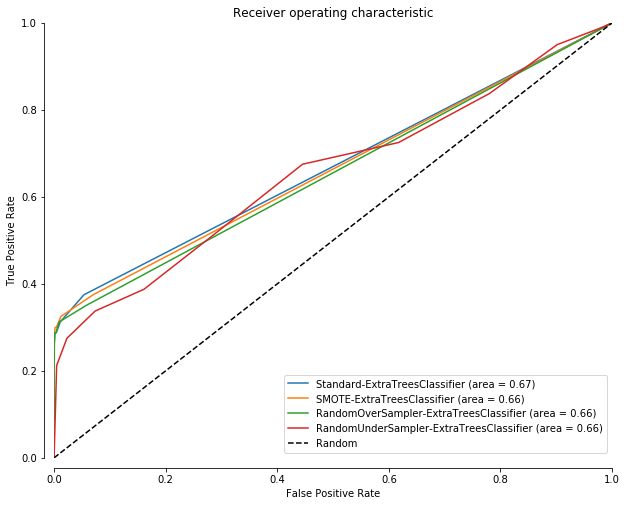

In [37]:
classifier = ['ExtraTreesClassifier', ExtraTreesClassifier()]

samplers = [
    ['Standard', DummySampler()],
    ['SMOTE', SMOTE(random_state=RANDOM_STATE)],
    ['RandomOverSampler', RandomOverSampler(random_state=RANDOM_STATE)],
    ['RandomUnderSampler', RandomUnderSampler(random_state=RANDOM_STATE)]
]

pipelines = [
    ['{}-{}'.format(sampler[0], classifier[0]),
     make_pipeline(sampler[1], classifier[1])]
    for sampler in samplers
]


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for name, clf in pipelines:
    
    clf.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, linestyle='-',
             label='{} (area = %0.2f)'.format(name) % roc_auc)
    
plt.plot([0, 1], [0, 1], linestyle='--', color='k',
         label='Random')    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

plt.legend(loc="lower right")

plt.show()    

## Выводы

* Практика -- залог успеха. Пробуйте различные подходы и алгоритмы для решения вашей задачи, комбинируйте их
* Перепроверяйте метрики, смотрите на задачу под правильным углом -- вы не тюните метрику, а решаете задачу

Ссылки:

* [Документация](http://contrib.scikit-learn.org/imbalanced-learn/index.html) imbalanced-learn
* [Пост](https://svds.com/learning-imbalanced-classes/) про работу с несбалансированными выборками, [FAQ](https://svds.com/imbalanced-classes-faq/) по ним и их [репозиторий](https://github.com/silicon-valley-data-science), откуда я взял Blagging Classifier и часть кода

